# Plotting refrigerant-ethanol viscosity data for RDD-2024 Poster

Data collected by Swetha Vutlapalli - 2023

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2023 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 27/04/2024
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

In [4]:
# Where data are stored.
directory = "/Users/dduke/Desktop/Swetha/"
filename = "ViscosityDataSummayReport.xlsx"

In [33]:
# Read data
data = {}
print("Reading %s" % filename)
for sheet_name in pd.ExcelFile(directory+filename).sheet_names:
    if 'in Ethanol' in sheet_name:
        print("\timport '"+sheet_name+"'")
        df = pd.read_excel(directory+filename, sheet_name=sheet_name)
        comp = df['Composition']
        ethww = []; m=None
        for c in comp:
            if isinstance(c,str): m=float(c.strip('e'))
            ethww.append(m/100.)
        theta = np.array(df['Inclination angle'])
        mu = np.array(1e6*df['mu_corrected'])
        data[sheet_name.split(' ')[0]]=(ethww,theta,mu)

Reading ViscosityDataSummayReport.xlsx
	import 'R134a in Ethanol'
	import 'R152a in Ethanol'
	import 'R1234ze in Ethanol'


In [38]:
# Pure property data at same temperature. (292.88K)

#Huber, M.L.; Laesecke, A.; Perkins, R.A., Model for the Viscosity and Thermal Conductivity of Refrigerants, Including a New Correlation for the Viscosity of R134a, Ind. Eng. Chem. Res., 2003, 42, 13, 3163-3178, https://doi.org/10.1021/ie0300880 . [all data]
#The uncertainty in viscosity is 1.5% along the saturated liquid line, 3% in the liquid phase, 0.5% in the dilute gas, 3-5% in the vapor phase, and 5% in the supercritical region, rising to 8% at pressures above 40 MPa. Below 200 K, the uncertainty is 8%.
R134a_mu = 208.06 # µPa-s

#Ian H. Bell and Arno Laesecke. Viscosity of refrigerants and other working fluids from residual entropy scaling . In 16th International Refrigeration and Air Conditioning Conference at Purdue, July 11-14, 2016. 2016.
R152a_mu = 173.31 # µPa-s
R1234_mu = 203.8 # µPa-s

#https://www.engineeringtoolbox.com/ethanol-dynamic-kinematic-viscosity-temperature-pressure-d_2071.html
Ethanol_mu = 1190 # µPa-s

pureProp={'R134a':R134a_mu, 'R152a':R152a_mu, 'R1234ze':R1234_mu}

## Plot all data vs ethanol mass fraction

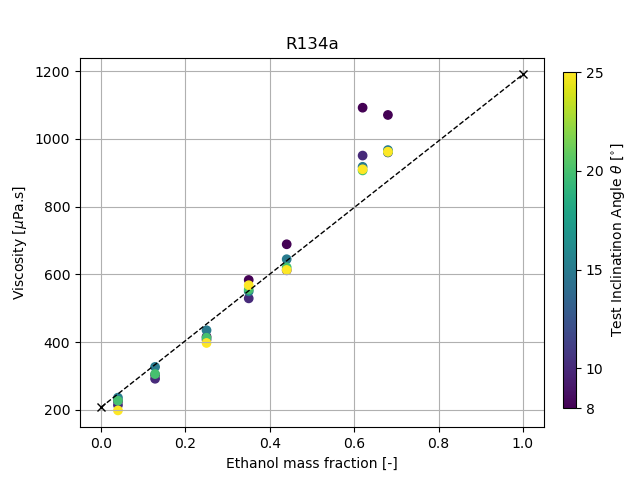

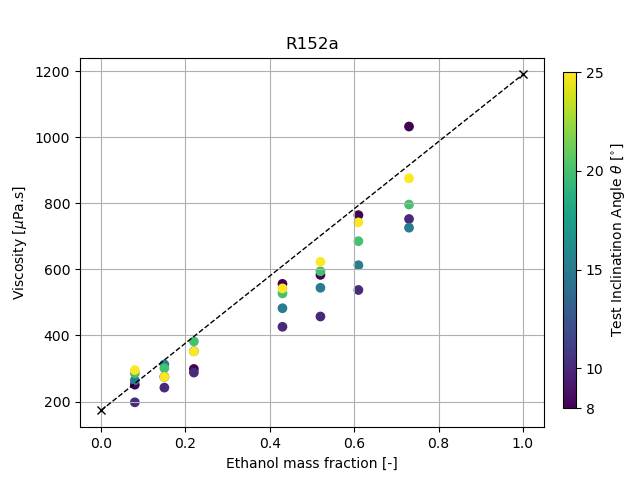

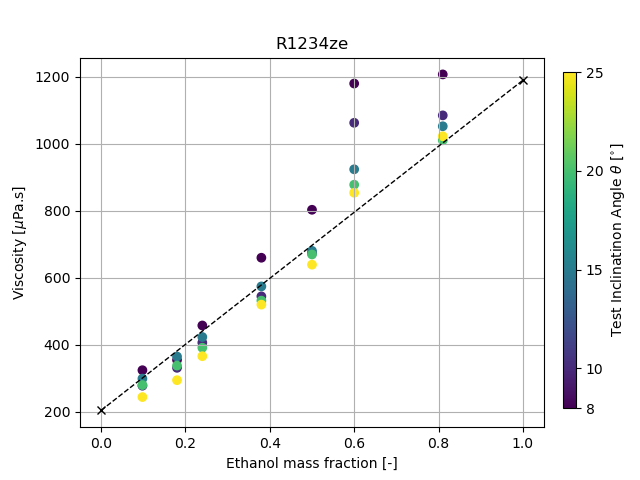

In [41]:
for d in data: # Loop propellants
    fig=plt.figure()
    plt.scatter(data[d][0],data[d][2],c=data[d][1]/25.)
    plt.plot([0, 1],[pureProp[d], Ethanol_mu],marker='x',c='k',ls='--',lw=1)
    
    plt.title(d)
    plt.grid()
    plt.ylabel(r'Viscosity [$\mu$Pa.s]')
    plt.xlabel('Ethanol mass fraction [-]')
    
    plt.subplots_adjust(right=0.85)
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cb = mpl.colorbar.ColorbarBase(cax, cmap='viridis',\
                                   norm=mpl.colors.Normalize(data[d][1].min(), data[d][1].max()),\
                                   ticks=np.unique(data[d][1]))
    cb.set_label(r'Test Inclinatinon Angle $\theta$ [$^{\circ}$]');

## Fit data to the residual entropy scaling function

- Ian H. Bell and Arno Laesecke. Viscosity of refrigerants and other working fluids from residual entropy scaling . In 16th International Refrigeration and Air Conditioning Conference at Purdue, July 11-14, 2016. 2016.